In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

In [2]:
#Filter the dataset to drop water injection wells
oil = pd.read_csv('D:\Work\ML_project\Oil.csv')
ver = pd.read_csv('D:\Work\ML_project\WS_COORDS_SUBSURF.csv')
clas = ver[['Conduit', 'Current Well Class']]
filtered = clas[clas['Current Well Class'] == 'DEVELOPMENT-OIL']
filtered1 = oil[oil['Conduit'].isin(filtered['Conduit'])]
print(filtered1)

       num            0            1            2            3            4  \
0        0  1132.000000  3269.000000  3210.000000  1608.000000  1461.000000   
1        1  1252.000000  1783.000000  1350.000000  1335.000000  1322.000000   
2        2  1011.000000  1507.000000  1420.000000  1353.000000  1087.000000   
3        3  1091.000000  1175.000000  1113.000000  1132.000000   989.000000   
4        4   909.000000  1320.420331   729.002378   903.909907   739.329457   
...    ...          ...          ...          ...          ...          ...   
4223  4223   519.698183   582.668215   467.609290   498.228613   424.690211   
4224  4224   386.436925   503.633028   405.963255   431.136658   409.117243   
4225  4225  1421.235568  1455.299506  1473.458621  1293.687075  1162.073326   
4226  4226  1274.376747  1243.990808  1220.862102  1163.261908  1118.678412   
4227  4227  1239.176642   997.580405  1139.607425  1143.724649  1120.685209   

                5            6            7        

In [5]:
#Filter the LSTM predictions to drop all the water injection wells
Pred = pd.read_csv('D:\Work\ML_project\Predictions.csv')
predicted_filtered = Pred.loc[filtered.index]
print(predicted_filtered)
#predicted_filtered.to_csv('filtered_dataset_with_coord.csv', index=False)
Pred['Conduit'] = oil['Conduit'].values

filtered0 = Pred[Pred['Conduit'].isin(filtered1['Conduit'])]
#filtered0.to_csv('filtered_predictions.csv', index=False)
c = pd.read_csv('D:\Work\ML_project\WS_COORDS_SURF.csv')
c_reset = c.reset_index(drop=True)
filtered2 = c.drop_duplicates(subset='Conduit', keep='first')

     Unnamed: 0            0            1            2           3  \
0             0   858.002500   824.584500   808.336500   787.96080   
1             1   638.957800   613.400900   600.545800   586.62350   
3             3   546.722400   525.084400   514.704900   503.30328   
5             5   903.107300   866.450300   847.073900   826.49780   
6             6  1113.315400  1067.047000  1041.861900  1017.46090   
..          ...          ...          ...          ...         ...   
870         870  1061.995800  1029.184100  1018.961200   982.47490   
871         871   687.693000   665.015800   656.743840   635.44574   
872         872   585.808700   566.879200   560.280300   541.84900   
878         878   272.801330   270.235780   260.181270   244.19351   
879         879    47.626774    42.083073    37.520767    44.32032   

              4          5  
0    762.445860  755.67096  
1    568.091000  563.75635  
3    487.398220  483.59790  
5    800.331200  794.30310  
6    985.52520

In [6]:
#Merge datasets to add coordinates columns
f = pd.read_csv('D:\\Work\\ML_project\\filtered_coordinates.csv')
m = pd.read_csv('D:\\Work\\ML_project\\filtered_predictions.csv')
f_relevant = f[['Conduit', 'Xcoord', 'Ycoord']]
m_updated = pd.merge(m, f_relevant, on='Conduit', how='left')
m_updated.to_csv('MAP.csv', index=False)

In [7]:
#Isolate the last 6 cases in the oil debit dataset
oil = pd.read_csv('D:\\Work\\ML_project\\filtered_dataset.csv')
g = pd.read_csv('D:\Work\ML_project\MAP.csv')
predictions = g.iloc[:, 1:7]  
true_values = oil.iloc[:, 25:31]
predictions.fillna(0, inplace=True)

In [8]:
#Calculate MSLE for the LSTM predicted values
row_wise_msle = []
for index, row in predictions.iterrows():
  
    y_true = true_values.iloc[index].values.reshape(1, -1)
    y_pred = predictions.iloc[index].values.reshape(1, -1)
    
    
    try:
        msle = mean_squared_log_error(y_true, y_pred)
    except ValueError:
        
        msle = np.nan  
    
    row_wise_msle.append(msle)


MAP_reduced = g.drop(g.columns[1:7], axis=1)
MAP_reduced['MSLE'] = row_wise_msle

print(MAP_reduced)

      Unnamed: 0 Conduit         Xcoord       Ycoord      MSLE
0              0    Sk-0  525321.431695  3346894.250  0.045098
1              1    Sk-0  525321.431695  3346894.250  0.042932
2              2    Sk-0  525321.431695  3346894.250  0.015061
3              3    Sk-0  525321.431695  3346894.250  0.409829
4              4    Sk-0  525321.431695  3346894.250  0.071836
...          ...     ...            ...          ...       ...
3829        4223  Sk-801  530140.559958  3338729.565  0.065244
3830        4224  Sk-801  530140.559958  3338729.565  0.067642
3831        4225  Sk-802  530140.559958  3338739.565  0.049252
3832        4226  Sk-802  530140.559958  3338739.565  0.026042
3833        4227  Sk-802  530140.559958  3338739.565  0.180303

[3834 rows x 5 columns]


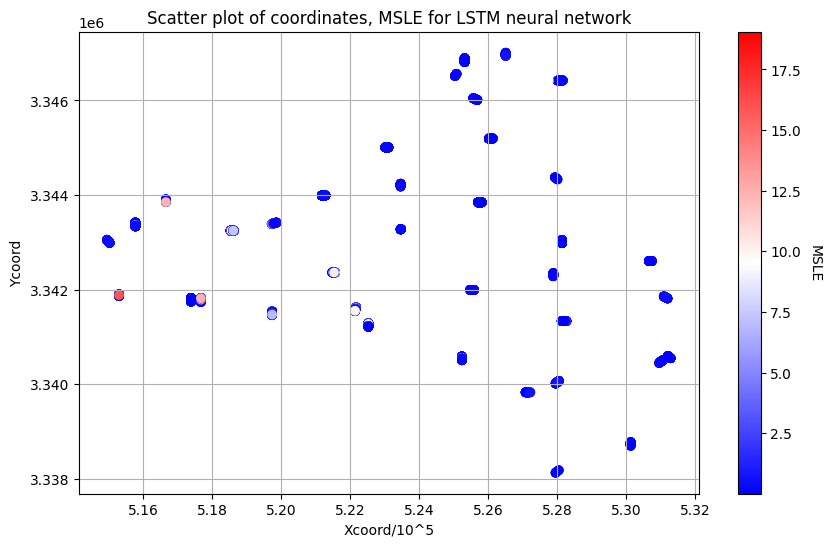

In [10]:
#Scatterplot the MSLEs of LSTM predictions of oil well debits in accordance to their coordinates
cmap = plt.get_cmap('bwr')
plt.figure(figsize=(10, 6), facecolor='white')
sc = plt.scatter(MAP_reduced['Xcoord']/100000, MAP_reduced['Ycoord'], c=MAP_reduced['MSLE'], cmap=cmap)
cbar = plt.colorbar(sc)
cbar.set_label('MSLE', rotation=270, labelpad=15)
plt.xlabel('Xcoord/10^5')
plt.ylabel('Ycoord')
plt.title('Scatter plot of coordinates, MSLE for LSTM neural network')
plt.grid()
plt.show()

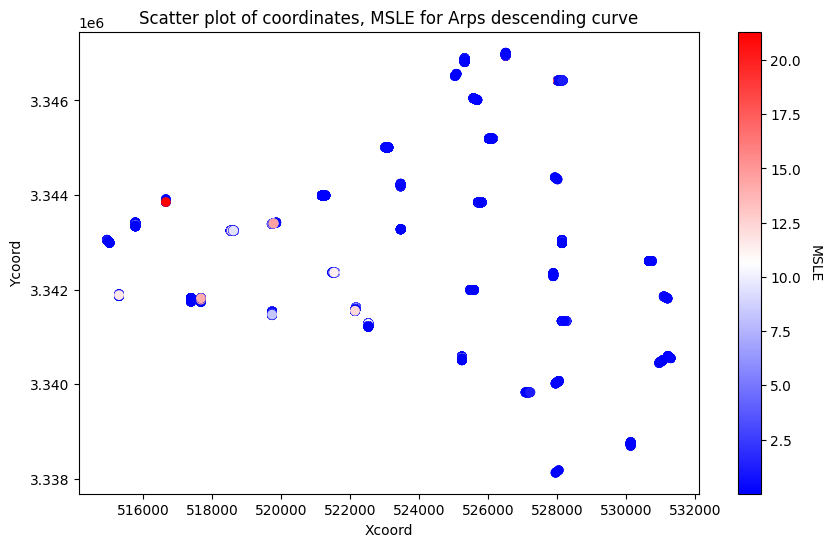

In [12]:
#Download the array of oil well's predicted debits with the Arps descention curve, drop the existing MSLE column, calculate MSLE for Arps method and scatter plot the new MSLE values in accordance to the coordinates of the oil wells 
array = np.load('D:\Work\ML_project\Arps_no_water.csv.npy')
MAP_reduced = MAP_reduced.drop(columns=['MSLE'])
MAP_reduced['MSLE'] = array
cmap = plt.get_cmap('bwr')

plt.figure(figsize=(10, 6))
sc = plt.scatter(MAP_reduced['Xcoord'], MAP_reduced['Ycoord'], c=MAP_reduced['MSLE'], cmap=cmap)

cbar = plt.colorbar(sc)
cbar.set_label('MSLE', rotation=270, labelpad=15)

plt.xlabel('Xcoord')
plt.ylabel('Ycoord')
plt.title('Scatter plot of coordinates, MSLE for Arps descending curve')
plt.show()

In [13]:
#Download clusterization results and fill the missing rows with zeroes
array0 = np.load('D:\Work\ML_project\lbl_zero.npy')
array1 = np.load('D:\Work\ML_project\lbl_one.npy')
max_length = max(len(array1), len(array0))
array0_padded = np.pad(array0, (0, max_length - len(array0)), 'constant')
array1_padded = np.pad(array1, (0, max_length - len(array1)), 'constant')
cl = pd.DataFrame({
    '0': array0_padded,
    '1': array1_padded
})
coord = pd.read_csv('D:\\Work\\ML_project\\MAP1.csv')
coord = coord.drop('Conduit', axis=1)

In [16]:
def map_well_to_coords(well_name):
    #Find the row where 'conduit' matches well_name
    row = coord.loc[coord['conduit'] == well_name]
    if not row.empty:
        #Return X and Y coordinates if exists
        return row.iloc[0]['Xcoord'], row.iloc[0]['Ycoord']
    else:
        #Return placeholders if no match
        return None, None

#Apply the function and unpack the results into separate columns
cl['0_Xcoord'], cl['0_Ycoord'] = zip(*cl['0'].apply(map_well_to_coords))
cl['1_Xcoord'], cl['1_Ycoord'] = zip(*cl['1'].apply(map_well_to_coords))
#cl.to_csv('filtered_predictions.csv', index=False)

         0       1       0_Xcoord    0_Ycoord       1_Xcoord     1_Ycoord
0     Sk-0    Sk-0  525321.431695  3346894.25  525321.431695  3346894.250
1     Sk-0    Sk-0  525321.431695  3346894.25  525321.431695  3346894.250
2     Sk-0    Sk-0  525321.431695  3346894.25  525321.431695  3346894.250
3     Sk-0    Sk-0  525321.431695  3346894.25  525321.431695  3346894.250
4     Sk-0    Sk-0  525321.431695  3346894.25  525321.431695  3346894.250
...    ...     ...            ...         ...            ...          ...
2201     0  Sk-798            NaN         NaN  527960.566170  3338128.390
2202     0  Sk-798            NaN         NaN  527960.566170  3338128.390
2203     0  Sk-801            NaN         NaN  530140.559958  3338729.565
2204     0  Sk-801            NaN         NaN  530140.559958  3338729.565
2205     0  Sk-801            NaN         NaN  530140.559958  3338729.565

[2206 rows x 6 columns]


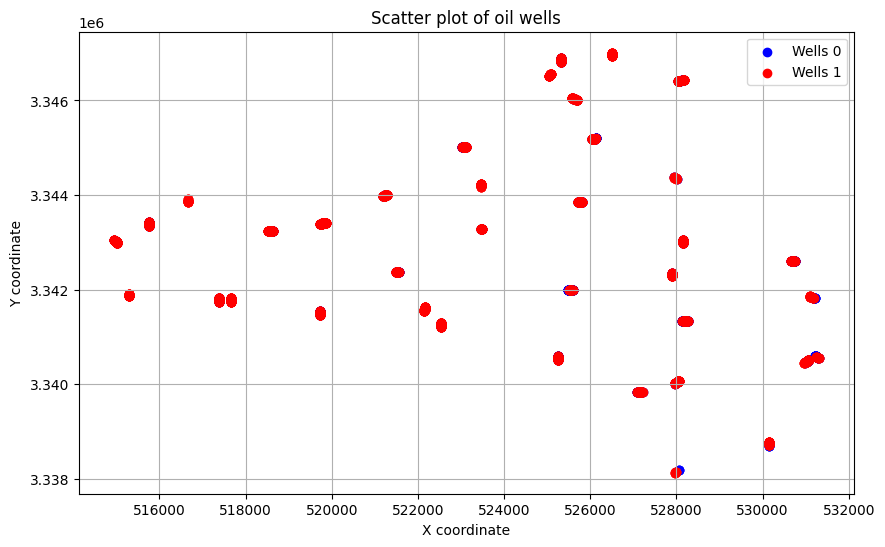

In [19]:
#Plot the results in accordance of their coordinates
clus = cl
plt.figure(figsize=(10, 6))


plt.scatter(clus['0_Xcoord'], clus['0_Ycoord'], c='blue', label='Wells 0')


plt.scatter(clus['1_Xcoord'], clus['1_Ycoord'], c='red', label='Wells 1')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Scatter plot of oil wells')
plt.legend()
plt.grid(True)
plt.show()